The focus of this notebook is to show the corrected CV procedure to test our model on forecasting windows of 864 samples.

In [3]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


2.7.0


In [4]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
# Load the dataset
df = pd.read_csv('../input/training/Training.csv')
print(df.shape)
df.head()
target_labels = df.columns

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


In [6]:
window = 300
stride = 20

In [7]:
def build_sequences(df, target_labels=['memes'], window=200, stride=20, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy()
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window
    
    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [8]:
telescope = 50

In [9]:
X, y = build_sequences(df, target_labels, window, stride, telescope)
X_lstm=X
X_lstm.shape, y.shape

((3418, 300, 7), (3418, 50, 7))

In [10]:
# perform k-fold splits
kf = KFold(n_splits=5, random_state=None, shuffle=False)
indexes = kf.split(X_lstm,y)
for train_index, test_index in indexes:
    print("TRAIN:", train_index[:10], "TEST:", test_index[:10])
    print("TRAIN:", train_index.shape, "TEST:", test_index.shape)

TRAIN: [684 685 686 687 688 689 690 691 692 693] TEST: [0 1 2 3 4 5 6 7 8 9]
TRAIN: (2734,) TEST: (684,)
TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [684 685 686 687 688 689 690 691 692 693]
TRAIN: (2734,) TEST: (684,)
TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [1368 1369 1370 1371 1372 1373 1374 1375 1376 1377]
TRAIN: (2734,) TEST: (684,)
TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [2052 2053 2054 2055 2056 2057 2058 2059 2060 2061]
TRAIN: (2735,) TEST: (683,)
TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [2735 2736 2737 2738 2739 2740 2741 2742 2743 2744]
TRAIN: (2735,) TEST: (683,)


In [11]:
input_shape = X_lstm.shape[1:]
print(input_shape)
output_shape = y.shape[1:]
print(output_shape)
batch_size = 64
epochs = 200

(300, 7)
(50, 7)


In [12]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    convlstm = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True))(input_layer)
    convlstm = tfkl.Conv1D(128, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.MaxPool1D()(convlstm)
    convlstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(convlstm)
    convlstm = tfkl.Conv1D(256, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.GlobalAveragePooling1D()(convlstm)
    convlstm = tfkl.Dropout(.5)(convlstm)

    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(convlstm)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

In [13]:
#initialize the list of metrics and models

mse = []
mae = []
rmse=[]
models = []

In [14]:
# function to build the 864 predition in a regressive way, it will be used to cross validate the models

def test_predict(model,X,test_index,dataset,window,telescope,stride):
    X_temp = tf.expand_dims(X, axis=0)
    reg_test_predictions=[]
    for reg in range(0,864,telescope):
            pred_temp= model.predict(X_temp)
            if (len(reg_test_predictions) == 0):
                reg_test_predictions = pred_temp
            else:
                reg_test_predictions = tf.concat([reg_test_predictions, pred_temp], axis=1)
                
            if(window<=telescope):
                X_temp = pred_temp[:,-window:]
                
            else:
                X_temp = tf.concat([X_temp[:, telescope:, :], pred_temp], axis=1)
                
    predictions=reg_test_predictions[0,:864,:]
    mean_squared_error = tfk.metrics.mse(tf.reshape(dataset[window+(stride*test_index):window+(stride*test_index)+864],(1,-1)),tf.reshape(predictions,(1,-1)))
    mean_absolute_error= tfk.metrics.mae(tf.reshape(dataset[window+(stride*test_index):window+(stride*test_index)+864],(1,-1)),tf.reshape(predictions,(1,-1)))
    rmse = np.sqrt(mean_squared_error.numpy())
    
  
    return mean_squared_error, mean_absolute_error, rmse, predictions
        
    

In [ ]:
originalData=pd.read_csv('../input/training/Training.csv')

In [17]:
#train all the models

i = 0
for train_index, test_index in kf.split(X,y):
    
    model = build_CONV_LSTM_model(input_shape, output_shape)
    history = model.fit(
    x = X_lstm[train_index],
    y = y[train_index],
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
    ).history
    
    models.append(model)
    i=i+1 

Epoch 1/200
39/39 [==============================] - 18s 96ms/step - loss: 98.6793 - mae: 7.4429 - val_loss: 79.3724 - val_mae: 6.2819 - lr: 0.0010
Epoch 2/200
39/39 [==============================] - 2s 57ms/step - loss: 68.6957 - mae: 5.9103 - val_loss: 69.5863 - val_mae: 5.4291 - lr: 0.0010
Epoch 3/200
39/39 [==============================] - 2s 58ms/step - loss: 59.2819 - mae: 5.1298 - val_loss: 65.1739 - val_mae: 4.8864 - lr: 0.0010
Epoch 4/200
39/39 [==============================] - 2s 58ms/step - loss: 54.9297 - mae: 4.7490 - val_loss: 64.5656 - val_mae: 4.7654 - lr: 0.0010
Epoch 5/200
39/39 [==============================] - 2s 58ms/step - loss: 51.6437 - mae: 4.4917 - val_loss: 63.7825 - val_mae: 4.7529 - lr: 0.0010
Epoch 6/200
39/39 [==============================] - 2s 57ms/step - loss: 48.6504 - mae: 4.2469 - val_loss: 62.8533 - val_mae: 4.5623 - lr: 0.0010
Epoch 7/200
39/39 [==============================] - 2s 58ms/step - loss: 46.3899 - mae: 4.0821 - val_loss: 61.7085 -

In [18]:
#models = []
n_folds = 5
# models can also be previously trained and then loaded for evaluation
#for i in range(n_folds):
    #single_model = tf.keras.models.load_model('../input/7-300-t-25-20/Tel100_w300_s20_n' + str(i))
    #models.append(single_model)
    #print(models)

 #Insert your preprocessing here


In [19]:
#function to draw the 864 samples test predictions

def draw_test_predictions(model,X,test_index,dataset,window,telescope,stride):
    mse,mae,rmse,predictions= test_predict(model=model,X=X_lstm[test_index], test_index=randTestIndex,dataset= originalData,window=window,telescope=telescope,stride=stride)
    igs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(target_labels):
        data1=np.array(dataset[stride*test_index:(stride*test_index)+window])
        data1=data1[:,i]
        data2=np.array(dataset[(stride*test_index)+window:(stride*test_index)+window+864])
        data2=data2[:,i]
        axs[i].plot(np.arange(window), data1)
        axs[i].plot(np.arange(window, 864+window), data2, color='orange')
        axs[i].plot(np.arange(window, 864+window),predictions[:,i], color='green')
    plt.show()
    return mse,mae,rmse,predictions

In [20]:
X1 = df
X1 = np.reshape(X1,(X1.shape[0],-1))
X1 = tf.expand_dims(X1, axis=0)

In [22]:
# perform the evaluation of the models by cross-validating them on their 864 predictions. 
# pick a random window within a model's test set, build the 864 samples prediction and compare it to the original dataset.

test_predictions = np.zeros((5,100,864,7))
mse1=np.zeros((5,100,1))
mae1=np.zeros((5,100,1))
rmse1=np.zeros((5,100,1))
df1 = pd.read_csv('../input/training/Training.csv')

   
i=0
print(kf.split(X_lstm,y))
for train_index, test_index in kf.split(X_lstm,y):
    print("Testing Model " + str(i))
    for n in range(100):
        randTestIndex=random.choice(test_index)
        while (((randTestIndex*stride)+window) >= (len(df)-window-864)):
            randTestIndex=random.choice(test_index)
        mse,mae,rmse,predictions= test_predict(model=models[i],X=X_lstm[randTestIndex], test_index=randTestIndex,dataset= originalData,window=window,telescope=telescope,stride=stride)
        test_predictions[i,n]=predictions
        mse1[i,n]=mse
        mae1[i,n]=mae
        rmse1[i,n]=rmse
    print("Model " + str(i) + " Tested")
    i=i+1

msemod0=np.mean(mse1[0])
maemod0=np.mean(mae1[0])
rmsemod0=np.mean(rmse1[0])

msemod1=np.mean(mse1[1])
maemod1=np.mean(mae1[1])
rmsemod1=np.mean(rmse1[1])

msemod2=np.mean(mse1[2])
maemod2=np.mean(mae1[2])
rmsemod2=np.mean(rmse1[2])

msemod3=np.mean(mse1[3])
maemod3=np.mean(mae1[3])
rmsemod3=np.mean(rmse1[3])

msemod4=np.mean(mse1[4])
maemod4=np.mean(mae1[4])
rmsemod4=np.mean(rmse1[4]) 



<generator object _BaseKFold.split at 0x7fca587368d0>
Testing Model 0
Model 0 Tested
Testing Model 1
Model 1 Tested
Testing Model 2
Model 2 Tested
Testing Model 3
Model 3 Tested
Testing Model 4
Model 4 Tested


In [23]:
# get the average and best performance
msetot=[msemod0,msemod1,msemod2,msemod3,msemod4]
maetot=[maemod0,maemod1,maemod2,maemod3,maemod4]
rmsetot=[rmsemod0,rmsemod1,rmsemod2,rmsemod3,rmsemod4]
print(rmsetot)
print("MSE on 864: " +str(tf.math.reduce_mean(msetot).numpy()))
print("MAE on 864: " +str(tf.math.reduce_mean(maetot).numpy()))
print("RMSE on 864: "+str( tf.math.reduce_mean(rmsetot).numpy()))
best=np.argmin(rmsetot)
print("Best Model: #"+str(best))

[9.883497681617737, 7.134697651863098, 9.24152986049652, 9.034571666717529, 9.156479439735413]
MSE on 864: 85.27045402145386
MAE on 864: 5.465926421165467
RMSE on 864: 8.89015526008606
Best Model: #1


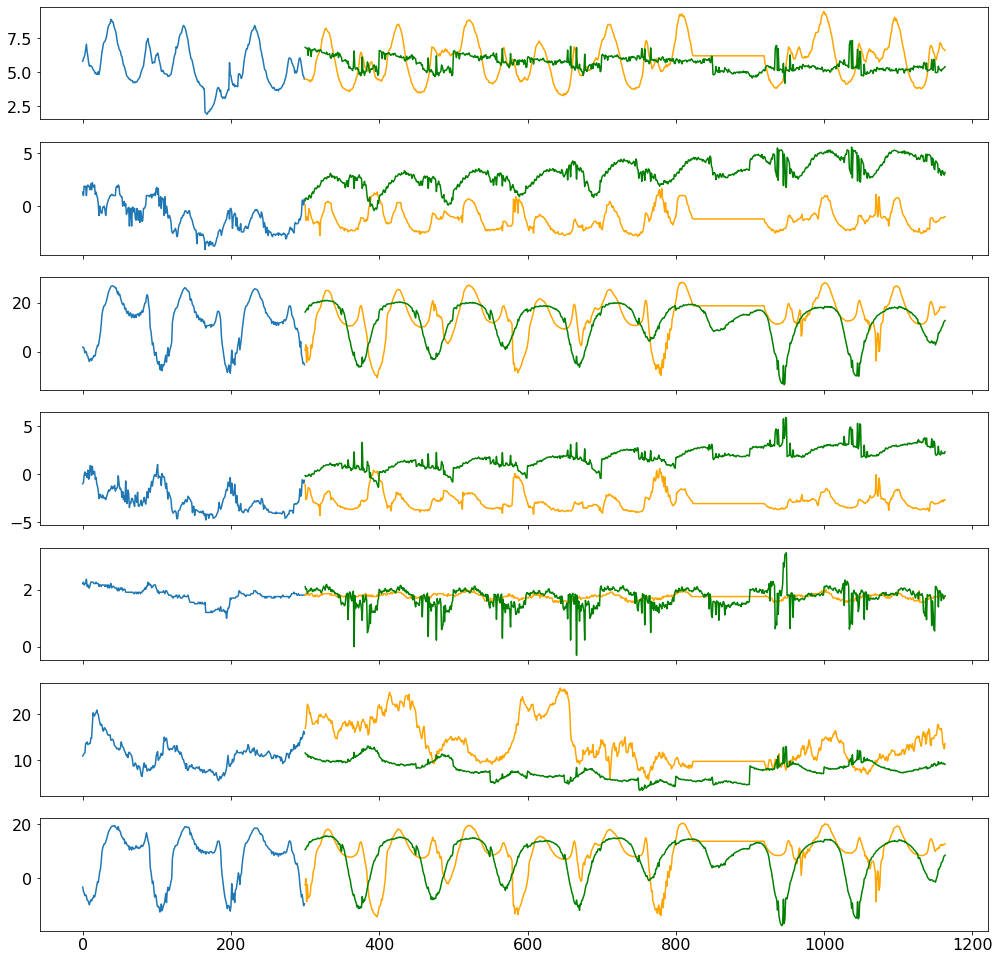

In [24]:
# draw best modolel 864 samples prediction and compare it to the actual values.
i=0
for train_index, test_index in kf.split(X_lstm,y):
    if(i==best):
        randTestIndex=random.choice(test_index)
        while (((randTestIndex*stride)+window) >= (len(df)-window-864)):
            randTestIndex=random.choice(test_index)
        draw_test_predictions(model=models[best],X=X_lstm[test_index], test_index=randTestIndex,dataset= originalData,window=window,telescope=telescope,stride=stride)
    i=i+1

In [25]:
# draw future predictions, so the 864 unknown values.
predictions = []
X = df
X = X[-window:]
X = tf.expand_dims(X, axis=0)
X_temp = X
reg_future = np.array([])
for reg in range(1,900,telescope):
    pred_temp = models[best].predict(X_temp)
    if (len(reg_future) == 0):
        reg_future = pred_temp
    else:
        reg_future = tf.concat([reg_future, pred_temp], axis=1)
    X_temp = tf.concat([X_temp[:, telescope:, :], pred_temp], axis=1)
out=reg_future[0,:864,:]
predictions.append(out)

In [26]:
out = tf.math.reduce_mean(predictions, axis=0 )

In [28]:
df1 = pd.read_csv('../input/training/Training.csv')
df1= df1.iloc[-300:]

(300, 7)


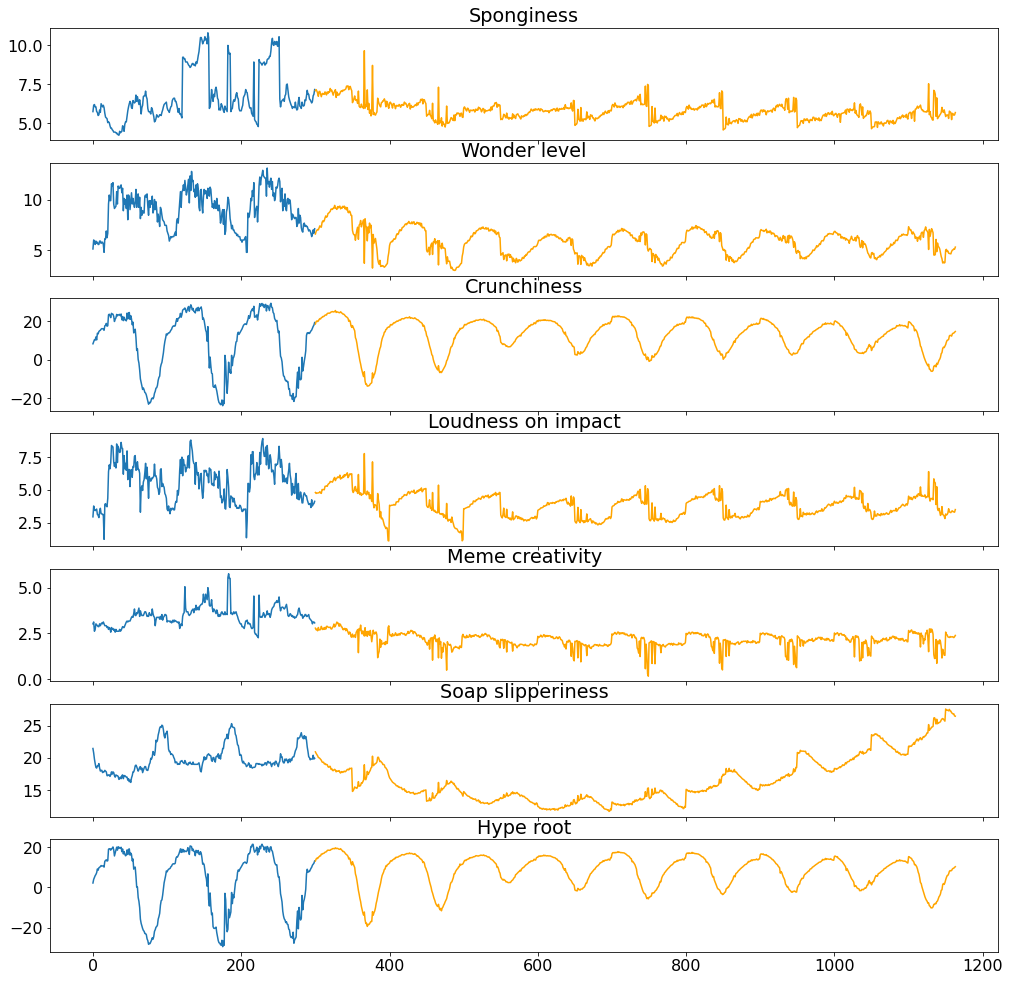

In [29]:
X_temp=np.array(df1)
print(X_temp.shape)
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(X_temp[:,i])), X_temp[:,i])
    axs[i].plot(np.arange(len(X_temp[:,i]), len(X_temp[:,i])+864), out[:,i], color='orange')
    axs[i].set_title(col)
plt.show()